In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import os, io
import pandas as pd
import matplotlib.pyplot as plt
from showit import image
import pprint

from starfish import data, FieldOfView
from starfish.types import Features, Axes

In [2]:
use_test_data = os.getenv("USE_TEST_DATA") is not None
experiment = data.ISS(use_test_data=use_test_data)

# s.image.squeeze() simply converts the 4D tensor H*C*X*Y into a list of len(H*C) image planes for rendering by 'tile'


## Show input file format that specifies how the tiff stack is organized

The stack contains multiple single plane images, one for each color channel, 'c', (columns in above image) and imaging round, 'r', (rows in above image). This protocol assumes that genes are encoded with a length 4 quatenary barcode that can be read out from the images. Each round encodes a position in the codeword. The maximum signal in each color channel (columns in the above image) corresponds to a letter in the codeword. The channels, in order, correspond to the letters: 'T', 'G', 'C', 'A'. The goal is now to process these image data into spatially organized barcodes, e.g., ACTG, which can then be mapped back to a codebook that specifies what gene this codeword corresponds to.

In [3]:
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(experiment._src_doc)

{ 'codebook': 'codebook.json',
  'extras': {},
  'images': { 'dots': 'dots.json',
              'nuclei': 'nuclei.json',
              'primary': 'hybridization.json'},
  'version': '5.0.0'}


The flat TIFF files are loaded into a 4-d tensor with dimensions corresponding to imaging round, channel, x, and y. For other volumetric approaches that image the z-plane, this would be a 5-d tensor.

In [4]:
fov = experiment.fov()
primary_image = fov.get_image(FieldOfView.PRIMARY_IMAGES)
dots = fov.get_image('dots')
nuclei = fov.get_image('nuclei')
images = [primary_image, nuclei, dots]

100%|██████████| 16/16 [00:00<00:00, 30.80it/s]
/usr/local/lib/python3.6/site-packages/slicedimage/_tile.py:36: UserWarning: Decoding tile just to obtain shape.  It is recommended to include the tile shape in the tileset document to avoid this.
  "Decoding tile just to obtain shape.  It is recommended to include the tile shape "
100%|██████████| 1/1 [00:00<00:00, 32.94it/s]


In [5]:
# round, channel, x, y, z
primary_image.xarray.shape

(4, 4, 1, 1044, 1390)

## Show auxiliary images captured during the experiment

'dots' is a general stain for all possible transcripts. This image should correspond to the maximum projcection of all color channels within a single imaging round. This auxiliary image is useful for registering images from multiple imaging rounds to this reference image. We'll see an example of this further on in the notebook

100%|██████████| 1/1 [00:00<00:00, 131.89it/s]


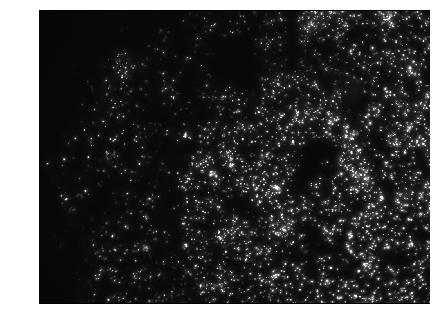

In [6]:
dots_mp = dots.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
dots_mp_numpy = dots._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
image(dots_mp_numpy)

Below is a DAPI auxiliary image, which specifically marks nuclei. This is useful cell segmentation later on in the processing.

100%|██████████| 1/1 [00:00<00:00, 110.40it/s]


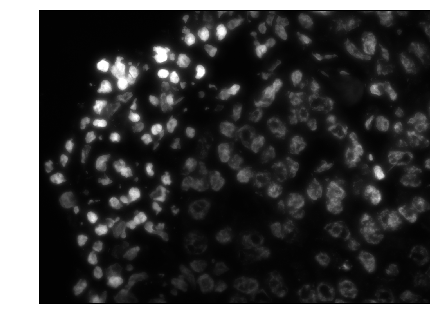

In [7]:
nuclei_mp = nuclei.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
nuclei_mp_numpy = nuclei_mp._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
image(nuclei_mp_numpy)

## Examine the codebook

Each 4 letter quatenary code (as read out from the 4 imaging rounds and 4 color channels) represents a gene. This relationship is stored in a codebook

In [8]:
experiment.codebook

<xarray.Codebook (target: 31, c: 4, r: 4)>
array([[[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]],

       [[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [1, 0, 0, 0]],

       ...,

       [[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]],

       [[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]], dtype=uint8)
Coordinates:
  * target   (target) object 'SCUBE2' 'MYBL2' 'ER' 'ST-3' 'BCL2' 'MET' ...
  * c        (c) int64 0 1 2 3
  * r        (r) int64 0 1 2 3

## Filter and scale raw data

Now apply the white top hat filter to both the spots image and the individual channels. White top had enhances white spots on a black background.

In [9]:
from starfish.image import Filter

# filter raw data
masking_radius = 15
filt = Filter.WhiteTophat(masking_radius, is_volume=False)
for img in images:
    filt.run(img, verbose=True, in_place=True)

16it [00:00, 237.18it/s]
1it [00:00, 17.76it/s]
1it [00:00, 11.91it/s]


## Register data

For each imaging round, the max projection across color channels should look like the dots stain.
Below, this computes the max projection across the color channels of an imaging round and learns the linear transformation to maps the resulting image onto the dots image.

The Fourier shift registration approach can be thought of as maximizing the cross-correlation of two images.

In the below table, Error is the minimum mean-squared error, and shift reports changes in x and y dimension.

In [10]:
from starfish.image import Registration

registration = Registration.FourierShiftRegistration(
    upsampling=1000,
    reference_stack=dots,
    verbose=True)
registered_image = registration.run(primary_image, in_place=False)

100%|██████████| 1/1 [00:00<00:00, 114.74it/s]


For round: 0, Shift: [  5.788 -22.819], Error: 0.5738049024566524
For round: 1, Shift: [  1.88  -22.189], Error: 0.7196118658307065
For round: 2, Shift: [ -3.245 -21.912], Error: 0.8182548925522324
For round: 3, Shift: [ -4.425 -14.923], Error: 0.8024235927697199


## Use spot-detector to create 'encoder' table  for standardized input  to decoder

Each pipeline exposes an encoder that translates an image into spots with intensities.  This approach uses a Gaussian spot detector.

In [11]:
from starfish.spots import SpotFinder
import warnings

# parameters to define the allowable gaussian sizes (parameter space)
min_sigma = 1
max_sigma = 10
num_sigma = 30
threshold = 0.01

p = SpotFinder.BlobDetector(
    min_sigma=min_sigma,
    max_sigma=max_sigma,
    num_sigma=num_sigma,
    threshold=threshold,
    measurement_type='mean',
)

# detect triggers some numpy warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # blobs = dots; define the spots in the dots image, but then find them again in the stack.
    dots = dots.max_proj(Axes.ROUND, Axes.ZPLANE)
    dots_numpy = dots._squeezed_numpy(Axes.ROUND, Axes.ZPLANE)
    blobs_image = dots_numpy
    intensities = p.run(registered_image, blobs_image=blobs_image)

100%|██████████| 1/1 [00:00<00:00, 126.95it/s]


 The Encoder table is the hypothesized standardized file format for the output of a spot detector, and is the first output file format in the pipeline that is not an image or set of images

`attributes` is produced by the encoder and contains all the information necessary to map the encoded spots back to the original image

`x, y` describe the position, while `x_min` through `y_max` describe the bounding box for the spot, which is refined by a radius `r`. This table also stores the intensity and spot_id.

## Decode

Each assay type also exposes a decoder. A decoder translates each spot (spot_id) in the Encoder table into a gene (that matches a barcode) and associates this information with the stored position. The goal is to decode and output a quality score that describes the confidence in the decoding.

There are hard and soft decodings -- hard decoding is just looking for the max value in the code book. Soft decoding, by contrast, finds the closest code by distance (in intensity). Because different assays each have their own intensities and error modes, we leave decoders as user-defined functions.

In [12]:
decoded = experiment.codebook.decode_per_round_max(intensities)

## Compare to results from paper

First just get the spots that passed the decoding thresholds

In [13]:
decoded_passed = decoded.loc[decoded[Features.PASSES_THRESHOLDS]==True]

Select the spots in round 0, channel 1

In [14]:
decoded_0_1 = decoded_passed.sel({Axes.ROUND: 0, Axes.CH: 1})
decoded_0_3 = decoded_passed.sel({Axes.ROUND: 0, Axes.CH: 3})
decoded_1_1 = decoded_passed.sel({Axes.ROUND: 1, Axes.CH: 1})

### Segment

100%|██████████| 1/1 [00:00<00:00, 86.83it/s]
/usr/local/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


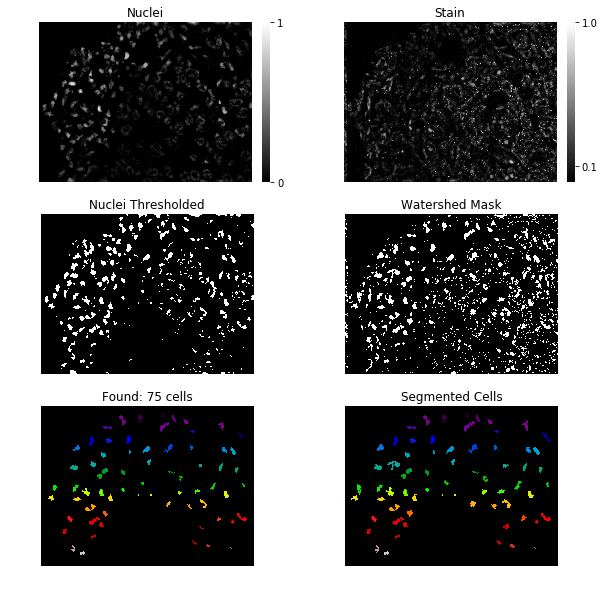

In [15]:
from starfish.image import Segmentation

dapi_thresh = .16  # binary mask for cell (nuclear) locations
stain_thresh = .22  # binary mask for overall cells // binarization of stain
min_dist = 57

registered_mp = registered_image.max_proj(Axes.CH, Axes.ZPLANE)
registered_mp_numpy = registered_mp._squeezed_numpy(Axes.CH, Axes.ZPLANE)
stain = np.mean(registered_mp_numpy, axis=0)
stain = stain/stain.max()
nuclei = nuclei.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
nuclei_numpy = nuclei._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)

seg = Segmentation.Watershed(
    nuclei_threshold=dapi_thresh,
    input_threshold=stain_thresh,
    min_distance=min_dist
)
label_image = seg.run(registered_image, nuclei)
seg.show()

### Visualize results

100%|██████████| 1/1 [00:00<00:00, 101.44it/s]


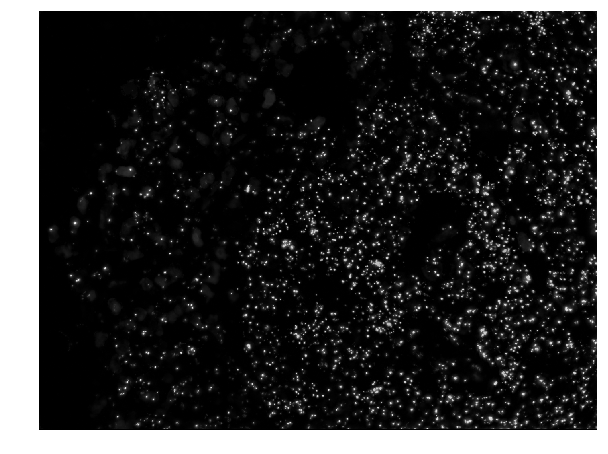

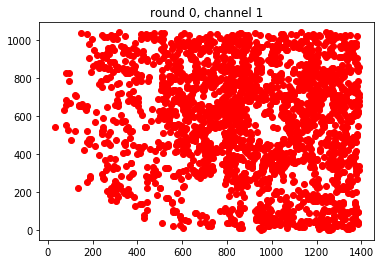

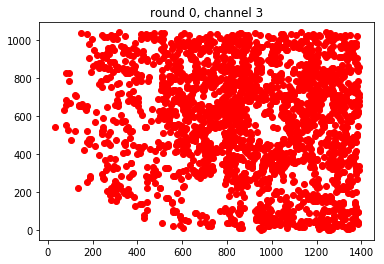

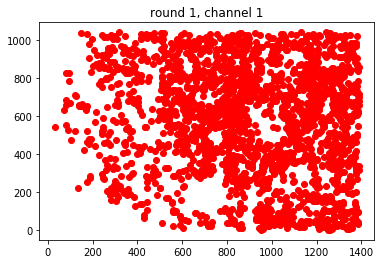

In [16]:
from skimage.color import rgb2gray

rgb = np.zeros(registered_image.tile_shape + (3,))
nuclei_mp = nuclei.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
nuclei_numpy = nuclei_mp._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,0] = nuclei_numpy
dots_mp = dots.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
dots_mp_numpy = dots_mp._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,1] = dots_mp_numpy
do = rgb2gray(rgb)
do = do/(do.max())

image(do,size=10)
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore', FutureWarning)
#     is_gene1 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE1, drop=True)
#     is_gene2 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE2, drop=True)

fig = plt.figure()
plt.plot(decoded_0_1.x, decoded_0_1.y, 'or')
plt.title('round 0, channel 1')
plt.show()

fig = plt.figure()
plt.plot(decoded_0_3.x, decoded_0_3.y, 'or')
plt.title('round 0, channel 3')
plt.show()

fig = plt.figure()
plt.plot(decoded_1_1.x, decoded_1_1.y, 'or')
plt.title('round 1, channel 1')
plt.show()

In [17]:
decoded_0_1_x = list(np.asarray(decoded_0_1.x))
decoded_0_1_y = list(np.asarray(decoded_0_1.y))
decoded_0_3_x = list(np.asarray(decoded_0_3.x))
decoded_0_3_y = list(np.asarray(decoded_0_3.y))
decoded_1_1_x = list(np.asarray(decoded_1_1.x))
decoded_1_1_y = list(np.asarray(decoded_1_1.y))

In [18]:
np.savetxt('decoded_0_1_x.csv', decoded_0_1_x, delimiter=',')
np.savetxt('decoded_0_3_x.csv', decoded_0_3_x, delimiter=',')
np.savetxt('decoded_1_1_x.csv', decoded_1_1_x, delimiter=',')
np.savetxt('decoded_0_1_y.csv', decoded_0_1_y, delimiter=',')
np.savetxt('decoded_0_3_y.csv', decoded_0_3_y, delimiter=',')
np.savetxt('decoded_1_1_y.csv', decoded_1_1_y, delimiter=',')